# Machine Learning and Statistics Project 2020

## Introduction 

In this project contains a web service that uses machine learning to make predictions based on the data set powerproduction available on Moodle. The goal is to
produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set.
The web service that will respond with predicted power values based on speed values sent as HTTP requests. 
This project contains the following 
1. Jupyter notebook that trains a model using the data set. Description of the model and give an analysis of its accuracy.
2. Python script that runs a web service based on the model,.
3. Dockerfile to build and run the web service in a container.
4. Standard items in a git repository such as a README

In [1]:
# import liberires used in project 
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 

### The Dataset

This study we try to clustering power production using  Kmeans and tensorflow

Attribute Information:

speed km/s
power KW/S


In [2]:
df = pd.read_csv("powerproductionDataSet.csv")

In [3]:
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


#### Let’s have a look at our data through a scatter plot.

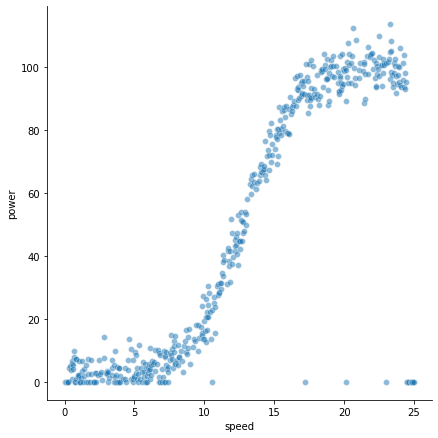

In [5]:
sns.relplot(x="speed", y="power",  alpha=.5, palette="muted",height=6, data=df)

In [6]:
correlations = df.corr()

In [7]:
correlations

,speed,power
speed,1.000000,0.853778
power,0.853778,1.000000


<AxesSubplot:>

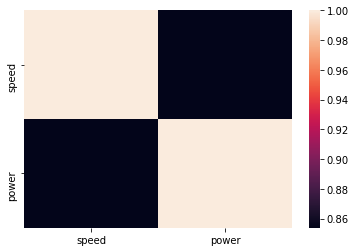

In [8]:
sns.heatmap(correlations)

## KMeans Clustering 

K-Means Clustering is an unsupervised machine learning algorithm. K-Means trys to classify data without having first been trained with labeled data. Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the most relevant group [[2]](https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203)

### How it works 
1. Select K (i.e. 2) random points as cluster centers called centroids
2. Assign each data point to the closest cluster by calculating its distance with respect to each centroid
3. Determine the new cluster center by computing the average of the assigned points
4. Repeat steps 2 and 3 until none of the cluster assignments change

### Choosing the right number of clusters (Elbow Method)
A graph of the relationship between the number of clusters and Within Cluster Sum of Squares (WCSS) then select the number of clusters where the change in WCSS begins to level off (elbow method). WCSS is defined as the sum of the squared distance between each member of the cluster and its centroid.

$$WSS=\sum^m_{i=1}(x_i -c_i)^2$$

In [9]:
# Code from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df) 
    kmeanModel.fit(df)

    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / df.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


In [10]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))

1 : 39.794016660463875
2 : 11.481870938448166
3 : 7.7370585714187055
4 : 6.149803457487902
5 : 5.406421043319489
6 : 4.889577711535056
7 : 4.2371200305422265
8 : 3.6807041849044575
9 : 3.3452118284614563


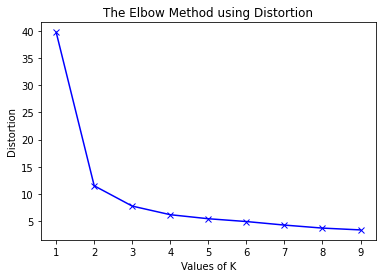

In [11]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

To determine the optimal number of clusters,select the value of k at the elbow ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus concludes that the optimal number of clusters for the data is 3.

Next, categorize the data using the optimum number of clusters (3)  k-means++ ensures that you get don’t fall into the random initialization trap.

In [14]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=0)

In [15]:
new_labels = kmeans.labels_
df['label'] = new_labels

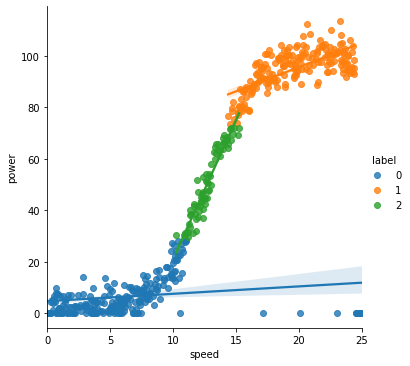

In [16]:
sns.lmplot(x="speed", y="power", hue="label", data=df)

In [23]:
np.polyfit(df['speed'],df['power'],1)

array([  4.91759567, -13.89990263])

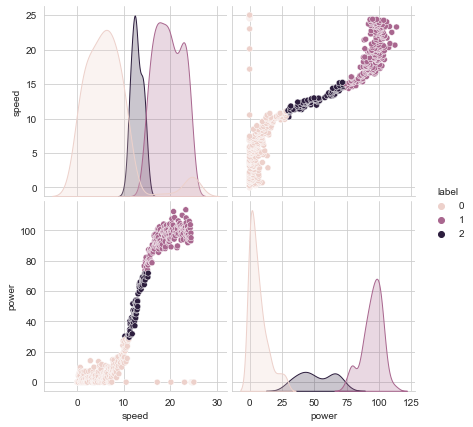

In [18]:
sns.set_style("whitegrid")
sns.pairplot(df,hue="label",height=3);
plt.show()

# Referenses 

1. GeeksForGeeks, Elbow Method for optimal value of k in KMeans,  https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

2. Cory Maklin, Dec 28, 2018, K-means Clustering Python Example, https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203



